# AWS re:Invent Machine Learning Builders' Session

#### WPS302: Identify improper payments with analytics and ML (Lab 1)

---

## Introduction
#### Since 2003, the US federal government has made approximately $\$$1.7 trillion in improper payments, with an estimated $\$$206 billion made in FY 2020 alone. Improper payments are now anticipated to increase proportionally to new levels of federal spending, from the $\$$1 trillion infrastructure bill, to the anticipated $\$$3.5 trillion budget reconciliation plan.

#### *How can we go beyond basic heuristic rulesets to help agencies identify improper payments at scale?*

#### **In this lab we'll demonstrate how to train a classification model on an imbalanced dataset to predict fraudulent Medicare providers using the XGBoost algorithm. Additionally, we'll demonstrate using the Sagemaker Estimator and Real-time inference endpoints.**

</p>

#### **Let's get started!**

---

## 1. Setup
<a id=section_1_0></a>

### 1.1 Prerequisites
<a id=section_1_1></a>

In [ ]:
!pip install imblearn
#!pip install sagemaker
!pip install matplotlib

### 1.2 Import packages and modules
<a id=section_1_2></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# AWS SDK for Python and Sagemaker packages
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

from math import sqrt

# Imbalanced-learn packages
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# sklearn packages
from sklearn.datasets import dump_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score, 
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,    
    plot_confusion_matrix,
    roc_auc_score
)

%matplotlib inline

### 1.3 Global config settings
<a id=section_1_3></a>

In [7]:
# Set lab name
lab_name = 'lab1'

# Allow viewing of all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create directory to store lab contents
data_dir = './data/{}'.format(lab_name)

if not os.path.exists('./data'):
    os.mkdir('./data')

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

### 1.4 Global config variables
<a id=section_1_4></a>

In [ ]:
# Get the IAM role and Sagemaker session
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

# Get the SakeMaker session
session = sagemaker.Session()

print('Using IAM role arn: {}'.format(role))

In [9]:
# Setup the S3 client
s3_client = boto3.client('s3')

# Set S3 settings
bucket = session.default_bucket()
prefix = 'fraud-detect-demo'

print('Using S3 path: s3://{}/{}'.format(bucket, prefix))

Using S3 path: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo


## 2. Exploratory Data Analysis
<a id=section_2_0></a>

### 2.1 Read the preprocessed medicare data
<a id=section_2_1></a>

In [10]:
data = pd.read_csv('./data/processed_data_classification_v2.csv', delimiter=',')

### 2.2 View the dimensions of the dataset (#rows, #cols)
<a id=section_2_2></a>

In [11]:
data.shape

(5500, 50)

### 2.3 Visually inspect the first few rows in the dataset
<a id=section_2_3></a>

In [12]:
data.head()

,fraudulent_provider,female,tot_suplrs_standard_deviation,tot_suplrs_mean,tot_suplrs_sum,tot_suplr_benes_standard_deviation,tot_suplr_benes_mean,tot_suplr_benes_sum,tot_suplr_clms_standard_deviation,tot_suplr_clms_mean,tot_suplr_clms_sum,tot_suplr_srvcs_standard_deviation,tot_suplr_srvcs_mean,tot_suplr_srvcs_sum,avg_suplr_sbmtd_chrg_standard_deviation,avg_suplr_sbmtd_chrg_mean,avg_suplr_sbmtd_chrg_sum,avg_suplr_mdcr_pymt_amt_standard_deviation,avg_suplr_mdcr_pymt_amt_mean,avg_suplr_mdcr_pymt_amt_sum,bene_unique_cnt_mean,bene_unique_cnt_sum,bene_unique_cnt_standard_deviation,line_svc_cnt_mean,line_svc_cnt_sum,line_svc_cnt_standard_deviation,bene_day_srvc_cnt_mean,bene_day_srvc_cnt_sum,bene_day_srvc_cnt_standard_deviation,average_submitted_chrg_amt_mean,average_submitted_chrg_amt_sum,average_submitted_chrg_amt_standard_deviation,average_medicare_payment_amt_mean,average_medicare_payment_amt_sum,average_medicare_payment_amt_standard_deviation,total_claim_count_mean,total_claim_count_sum,total_claim_count_standard_deviation,total_30_day_fill_count_mean,total_30_day_fill_count_sum,total_30_day_fill_count_standard_deviation,total_day_supply_mean,total_day_supply_sum,total_day_supply_standard_deviation,total_drug_cost_mean,total_drug_cost_sum,total_drug_cost_standard_deviation,bene_count_mean,bene_count_sum,bene_count_standard_deviation
0,0,0,0,2,12,0,5,30,8,26,157,8,26,157,221.545084,281.291774,1687.750642,40.267402,51.756601,310.539608,61,2019,45,87,2894,97,87,2894,97,612.122842,20200.053790,276.195300,83.302926,2748.996574,33.577014,16,872,5,16.739623,887.2,6.144614,358,19016,225,679.101887,35992.40,1257.721840,7,400,4
1,0,1,3,4,390,8,11,1090,43,45,4214,1673,733,68183,648.536077,205.158603,19079.750090,126.268278,37.013509,3442.256332,74,13133,59,306,54166,457,199,35224,241,76.912131,13613.447170,65.999303,17.927735,3173.209053,21.273936,46,48942,53,62.092727,64886.9,75.053557,1709,1786163,2203,2399.843091,2507836.03,4524.335169,12,13508,14
2,0,1,4,4,290,5,7,423,20,25,1508,1745,706,41682,96.672171,79.101150,4666.967838,26.030407,21.551856,1271.559511,33,1128,25,67,2287,78,67,2287,78,133.688857,4545.421138,56.698190,67.149802,2283.093266,36.452336,50,48262,55,66.317066,63730.7,79.181677,1929,1854601,2389,2151.969084,2068042.29,4477.550876,11,11119,11
3,0,0,1,1,41,2,6,128,7,19,400,8,21,452,1483.976776,958.574271,20130.059680,879.222640,516.165752,10839.480790,130,31506,145,171,41456,232,160,38869,228,309.875494,74989.869460,326.187181,91.143027,22056.612430,79.139884,78,36671,101,175.826882,81759.5,255.800821,5220,2427675,7657,5472.788065,2544846.45,19909.428210,24,11364,32
4,0,0,4,4,333,9,9,677,25,35,2432,496,226,15402,168.249662,123.252361,8381.160563,53.286680,31.118151,2116.034257,83,11828,96,130,18498,218,129,18421,219,128.802917,18290.014170,158.839433,55.376012,7863.393671,59.656966,59,74114,71,100.573899,125616.8,148.234033,2858,3570133,4448,3955.478335,4940392.44,7644.742211,15,19910,18


### 2.4 Check data for any nulls
<a id=section_2_4></a>

In [13]:
data.isnull().values.any()

False

### 2.5 Check for imbalance
<a id=section_2_5></a>

Review the target (fraudulent_provider) value counts to check for imbalance

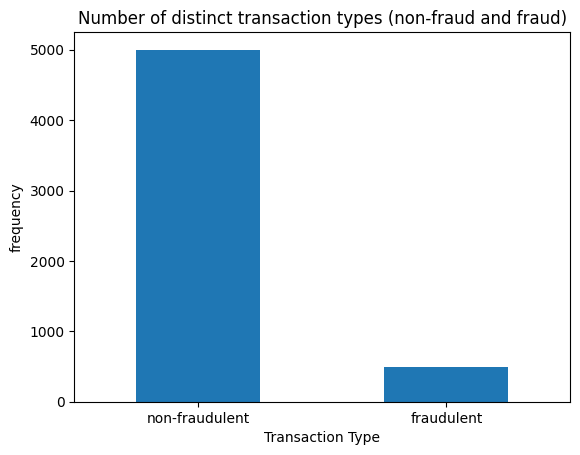

There are 5000 non-fradulent records and 500 fradulent records


In [14]:
fig, ax = plt.subplots()
data['fraudulent_provider'].value_counts().plot(ax = ax, kind = 'bar', ylabel = 'frequency', xlabel = 'Transaction Type')
plt.xticks(range(2), ['non-fraudulent', 'fraudulent'], rotation=0)
plt.title(label="Number of distinct transaction types (non-fraud and fraud)",
          fontsize=12,
          color="black")
plt.show()

print('There are {} non-fradulent records and {} fradulent records'.format(
    data['fraudulent_provider'].value_counts()[0], 
    data['fraudulent_provider'].value_counts()[1]))

We see that the majority of data is **non-fraudulent** transactions, however, our goal is to train a model to identify **fradulent** transactions. Attempting to train a model on this dataset (as-is) may yield a high accuracy score because accuracy is calculated as:

<pre>
Total Number of Correct Predictions / Total Number of Predictions
</pre>

As a result, the model will perform well when predicting the majority class, but perform poorly at predicting the minority class due to lack of training examples.

To address this challange, we will need to rebalance the dataset using sampling techniques that are designed to improve the performance of models that rely on imbalanced datasets. To help with this task, we'll use under and over sampling techniques from the [Imblearn package](https://imbalanced-learn.org/stable/user_guide.html#user-guide) 

## 3. Preprocessing
<a id=section_3_0></a>

### 3.1 Data Preparation
<a id=section_3_1></a>

Remove the column headers from the dataset as SageMaker does not need headers for processing CSV files

In [15]:
# Removing column headers from CSV file
feature_columns = data.columns[1:]
label_column = data.columns[0]

# Setting the datatype to float32
features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

Split the dataset into train and test sets to evaluate the performance of our model

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.5, stratify=labels)

Since the data is highly imbalanced, it is important to stratify across the data sets to ensure a near even distribution, so we set the test_size parameter to 0.5. The training dataset (X_train) will be used to fit the model and the testing dataset (X_test) will be used for predictions

Display the size of the training and test datasets after the train-test split

In [17]:
print('The training dataset contains {} total rows ({} non-fraudulent transactions, {} fraudulent transactions)'.format(len(y_train), (y_train == 0).sum(), (y_train == 1).sum()))
print('The test dataset contains {} total rows ({} non-fraudulent transactions, {} fraudulent transactions)'.format(len(y_test), (y_test == 0).sum(), (y_test == 1).sum()))

The training dataset contains 2750 total rows (2500 non-fraudulent transactions, 250 fraudulent transactions)
The test dataset contains 2750 total rows (2500 non-fraudulent transactions, 250 fraudulent transactions)


### 3.2 Applying Synthetic Minority Over-sampling (SMOTE)
<a id=section_3_2></a>

The [sampling strategy](https://imbalanced-learn.org/stable/auto_examples/api/plot_sampling_strategy_usage.html#sphx-glr-auto-examples-api-plot-sampling-strategy-usage-py) for resampling an imbalanced dataset is very important for improving the performance of the model. 

For this lab, we'll set the [SMOTE sampling strategy](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) to 0.95, which means SMOTE will create new samples until the minority class is equal to 95% of the majority class (2500 * 0.95 = 2375). Next, we'll set the [RandomUnderSampler sampling strategy](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) to 1.0, which means we'll reduce the number of samples in the majority class (2500) to equal the new minority class size (2375).

Feel free to expirement with different sampling strategy ratios to see the impact.

In [18]:
# Oversample the minority class with SMOTE 
over = SMOTE(random_state=42, sampling_strategy=0.95)

# Undersample the majority class to achieve about a 1:1 ratio.
# The minority class will be the same amount (1 to 1) as the majority class
under = RandomUnderSampler(random_state=42, sampling_strategy=1.0)

# Add steps to parameter list
steps = [('o', over), ('u', under)]

# Create imblearn.pipeline and pass steps
pipeline = Pipeline(steps=steps)

# Fit and apply to the CMS dataset in a single transform
X_smote, y_smote = pipeline.fit_resample(X_train, y_train)

### 3.3 Check for imbalance
<a id=section_3_3></a>

Review the target (fraudulent_provider) value counts to check for imbalance *after* applying data augmentation

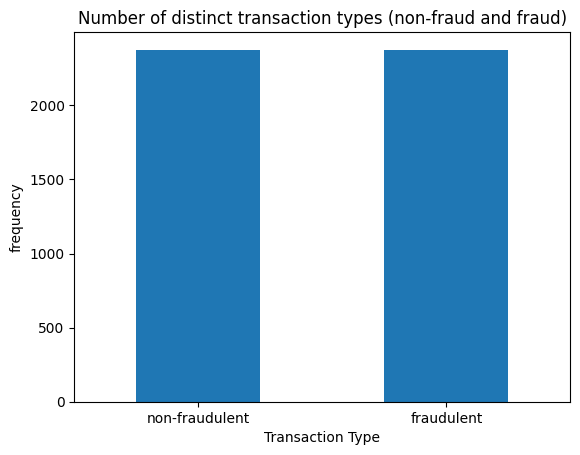

There are 2375 non-fradulent records and 2375 fradulent records


In [19]:
# Convert to DataFrame for plotting
df_y_smote = pd.DataFrame(y_smote.astype(int))

# Plot
fig, ax = plt.subplots()
df_y_smote.value_counts().plot(ax = ax, kind = 'bar', ylabel = 'frequency', xlabel = 'Transaction Type')
plt.xticks(range(2), ['non-fraudulent', 'fraudulent'], rotation=0)
plt.title(label="Number of distinct transaction types (non-fraud and fraud)",
          fontsize=12,
          color="black")
plt.show()

print('There are {} non-fradulent records and {} fradulent records'.format(
    df_y_smote.value_counts()[0], 
    df_y_smote.value_counts()[1]))

In [20]:
pct_chg = abs((len(df_y_smote) - len(data)) / len(data) * 100)

print('Observe that by applying SMOTE and RandomUnderSampling our dataset has decreased in size by {:.2f}% as a result of downsampling of the majority class and upsampling of the minority class'.format(pct_chg))

Observe that by applying SMOTE and RandomUnderSampling our dataset has decreased in size by 13.64% as a result of downsampling of the majority class and upsampling of the minority class


### 3.4 Test-train split for augmented dataset
<a id=section_3_4></a>

Split the augmented dataset - 80% will be used for training and 20% will be used for validation

In [21]:
X_smote_train, X_smote_validation, y_smote_train, y_smote_validation = train_test_split(
    X_smote, y_smote, test_size=0.2, stratify=y_smote)

Display the size of the training and test datasets after the train-test split

In [22]:
print('The training dataset contains {} total rows ({} non-fraudulent transactions, {} fraudulent transactions)'.format(len(X_smote_train), (y_smote_train == 0).sum(), (y_smote_train == 1).sum()))
print('The validation dataset contains {} total rows ({} non-fraudulent transactions, {} fraudulent transactions)'.format(len(X_smote_validation), (y_smote_validation == 0).sum(), (y_smote_validation == 1).sum()))

The training dataset contains 3800 total rows (1900 non-fraudulent transactions, 1900 fraudulent transactions)
The validation dataset contains 950 total rows (475 non-fraudulent transactions, 475 fraudulent transactions)


### 3.5 Prepare datasets for training and evaluation

Ensure the first column in the dataset are the labels, then convert to DataFrames. We'll use the training and validation datasets (which we have over and undersampled) for training the model. We'll use the testing dataset for model evaluation. 

In [23]:
# Rearrange the first column as target column
trainX_concate = np.concatenate((y_smote_train.reshape(len(y_smote_train),1), X_smote_train), axis=1)
trainX = pd.DataFrame(trainX_concate, index=None, columns=None)

validationX_concate = np.concatenate((y_smote_validation.reshape(len(y_smote_validation),1), X_smote_validation), axis=1)
validationX = pd.DataFrame(validationX_concate, index=None, columns=None)

testX = pd.DataFrame(X_test, index=None, columns=None)

Save the files locally in CSV format. After this step, there should be three new CSV files visible in the folder: **./data/lab1**

In [24]:
trainX.to_csv("{}/train.csv".format(data_dir), header=False, index=False)
validationX.to_csv("{}/validation.csv".format(data_dir), header=False, index=False)
testX.to_csv("{}/test.csv".format(data_dir), header=False, index=False)

### 3.6 Upload the datasets to S3

In [25]:
# Set the directory path in S3
subdir = '{}/smote'.format(lab_name)

train_path = session.upload_data(
    path="{}/train.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/training'.format(prefix, subdir)
)

validation_path = session.upload_data(
    path="{}/validation.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/validation'.format(prefix, subdir)
)

test_path = session.upload_data(
    path="{}/test.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/testing'.format(prefix, subdir)
)

Display the location of our datasets in S3

In [26]:
print('The S3 URI of the training dataset is: {}'.format(train_path))
print('The S3 URI of the validation dataset is: {}'.format(validation_path))
print('The S3 URI of the testing dataset is: {}'.format(test_path))

The S3 URI of the training dataset is: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab1/smote/training/train.csv
The S3 URI of the validation dataset is: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab1/smote/validation/validation.csv
The S3 URI of the testing dataset is: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab1/smote/testing/test.csv


### 3.7 Set the output location for model artifacts in S3

In [27]:
output_location = 's3://{}/{}/{}/output/'.format(bucket, prefix, subdir)
print('The S3 URI for model artifacts is: {}'.format(output_location))

The S3 URI for model artifacts is: s3://sagemaker-us-east-1-354457949231/fraud-detect-demo/lab1/smote/output/


## 4. Model Training
<a id=section_4_0></a>

### 4.1 Get the container URI for running XGBoost
<a id=section_4_1></a>

We will use the Amazon XGBoost supervised learning algorithm for classification

In [28]:
# Retrieves the ECR URI for the pre-built SageMaker XGBoost Docker image
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "latest")

print('Using container URI: {}'.format(container))

Using container URI: 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest


### 4.2 Train the model
<a id=section_4_2></a>

In this step, we train our XGBoost model via the SakeMaker estimator object. Estimators are a high level interface for SageMaker training for handling end-to-end Amazon SageMaker training and deployment tasks.

**Note: This step will initiate a Sagemaker Training Job and will take approximately 3-4 minutes to complete. As the Sagemaker Training Job is running there will be a lot of logging data generated, this is normal. The job is successfully completed when you see output similar to the following:**
<pre>
...
yyyy-mm-dd HH:mm:ss Completed - Training job completed
...
Training seconds: 163
Billable seconds: 163
</pre>

In [29]:
# Set basic hyperparams
hyperparams = {
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'num_round':200,    
    'silent':0,
    'seed':42    
}

# Create an Estimator object
clf = sagemaker.estimator.Estimator(container,
                                    role,
                                    hyperparameters=hyperparams,
                                    instance_count=1, 
                                    instance_type='ml.c5.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)


# Define the data type and paths to the training and validation datasets
content_type = "text/csv" 
train_input = TrainingInput(train_path, content_type=content_type)
validation_input = TrainingInput(validation_path, content_type=content_type)

# Fit the model
clf.fit({'train': train_input, 'validation': validation_input})

2022-11-10 20:17:51 Starting - Starting the training job...
2022-11-10 20:18:17 Starting - Preparing the instances for trainingProfilerReport-1668111471: InProgress
............
2022-11-10 20:20:20 Downloading - Downloading input data...
2022-11-10 20:20:51 Training - Training image download completed. Training in progress.
2022-11-10 20:20:51 Uploading - Uploading generated training modelArguments: train
[2022-11-10:20:20:42:INFO] Running standalone xgboost training.
[2022-11-10:20:20:42:INFO] File size need to be processed in the node: 1.79mb. Available memory size in the node: 256.98mb
[2022-11-10:20:20:42:INFO] Determined delimiter of CSV input is ','
[20:20:42] S3DistributionType set as FullyReplicated
[20:20:42] 3800x49 matrix with 186200 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-11-10:20:20:42:INFO] Determined delimiter of CSV input is ','
[20:20:42] S3DistributionType set as FullyReplicated
[20:20:42] 950x49 matrix with 46550 entri

## 5. Model Hosting
<a id=section_5_0></a>

### 5.1 Create a real-time inference endpoint
<a id=section_5_1></a>

Now we deploy the estimator to an endpoint.

**Note: This step will create an inference endpoint and will take approximately 3-4 minutes to complete. The task is successfully completed when you see output similar to the following:**

--------!

In [30]:
# Serialize data to a CSV-formatted string
csv_serializer = CSVSerializer()

# Create a real-time inference endpoint that hosts our trained model 
xgb_predictor = clf.deploy(initial_instance_count=1,
                       instance_type='ml.m5.xlarge', 
                       serializer=csv_serializer)

-------------------!

## 6. Model Evaluation
<a id=section_6_0></a>

Once we have trained the model we can use it to make predictions for the test set.

### 6.1 Create a wrapper function for model testing
<a id=section_6_1></a>

In [31]:
# Because we have a large test set, we call predict on smaller batches
def predict(current_predictor, df, rows=500):
    """
    A wrapper function to invoke the Estimator's predict function using
    a for loop. 
    
    Parameters:
        current_predictor: The sagemaker.estimator.Estimator object
        df: a DataFrame object containing observations without the target feature
        rows: number of observations passed to the predict function per batch
      
    Returns:
        predictions: An array of predictions (of dtype float64)
    """
    
    # Split an array into multiple sub-arrays by dividing num of observations by rows parameter
    split_array = np.array_split(df, int(df.shape[0] / float(rows) + 1))
    
    # Initialize variable to store prediction results
    predictions = ''
    
    # Call the Estimator's predict function
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    # Return
    return np.fromstring(predictions[1:], sep=',')

### 6.2 Test the model
<a id=section_6_2></a>

In [32]:
# Test the model by invoking the real-time inference endpoint with observations from the test dataset
raw_preds = predict(xgb_predictor, X_test)

In [33]:
# Let's have look a quick look at the first ten predictions (values between 0 and 1) returned by our trained model
print('The first ten raw predictions: {}'.format(np.round(raw_preds[:10], 3)))

The first ten raw predictions: [0.008 0.    0.012 0.073 0.211 0.    0.    0.    0.    0.   ]


Our next step is to determine the threshold for classifying each prediction as non-fradulent (0) or fradulent (1). For relatively balanaced datasets, the default binary classification threshold is typically **0.50**, meaning that a prediction below 0.50 is classified as non-fradulent (0), and a value above 0.50 is classified as fradulent (1). However, for highly imbalanced datasets, we need to adjust the classification threshold, a technique known as **threshold moving.**

### 6.3 Calculate balanced accuracy scores
<a id=section_6_3></a>

We will use a few measures from the scikit-learn package to evaluate the performance of our model. When dealing with an imbalanced dataset, we need to choose metrics that take into account the frequency of each class in the data.

We will use [balanced accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

We can bring a balance between the metrics again by adjusting our classification threshold (threshold between labeling a point as fraud or not). We can try different thresholds to see if they affect the result of the classification.

In [34]:
# Calculate balanced accuracy scores for different threshold values
proposed_treshold = 0.0
proposed_score = 0.0

# Iterate over 1000 values between 0.1 and 0.99 to find the maximum balanced accuracy score and classification threshold
for thres in np.linspace(0.1, 0.99, num=1000):
    smote_thres_preds = np.where(raw_preds > thres, 1, 0)
    score = balanced_accuracy_score(y_test, smote_thres_preds)
    
    # Set the max score    
    if proposed_score <= score:
        proposed_score = score
        proposed_treshold = thres

In [35]:
print('We will use the binary classification threshold of {:.5f} as it yields the highest balanced accuracy score: {:.5f}'.format(proposed_treshold, proposed_score))

We will use the binary classification threshold of 0.11960 as it yields the highest balanced accuracy score: 0.74840


In [36]:
# Use the proposed threshold to convert the predictions returned by the model to 0 or 1.
y_preds = np.where(raw_preds >= proposed_treshold, 1, 0)

In [37]:
# Let's have a quick look at the first ten predictions after applying the proposed binary classification threshold
print('The first ten binary class predictions: {}'.format(np.round(y_preds[:10], 3)))

The first ten binary class predictions: [0 0 0 0 1 0 0 0 0 0]


### 6.4 Plot results in a confusion matrix
<a id=section_6_4></a>

Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, per-class precision, recall and f1-scores can also provide more information about the model's performance.

In [38]:
def plot_confusion_matrix(y_true, y_predicted):
    
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_predicted,
        display_labels=['Non Fraud', 'Fraud'],
        cmap='cividis')

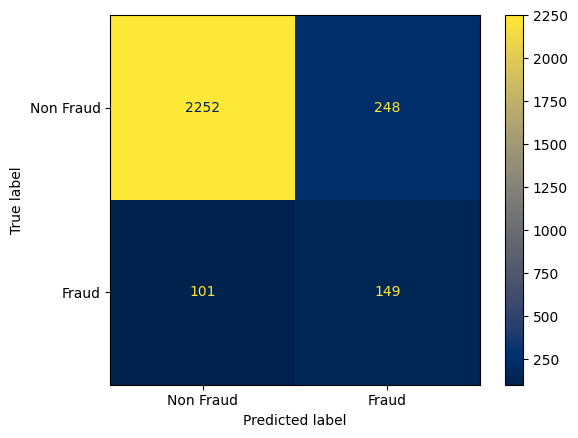

In [39]:
# Display the confusion matrix
plot_confusion_matrix(y_test, y_preds)

Let's interpret the results from the confusion matrix:

The *positive class* (1) is **fraud** and the *negative class* (0) is **non-fraud**.

- True Negatives (top left): 2220 transactions were labeled as *non-fraud* and the model correctly classified them as *non-fraud*.
- True Positives (bottom right): 164 transactions were labeled as *fraud* and the model correctly classified them as *fraud*
- False Positives (top right): 280 transactions were labled as *non-fraud* and the model incorrectly classified them as *fraud*.
- False Negatives (bottom left): 86 transactions were labled as *fraud* and the model incorrectly classified them as *non-fraud*.

Note: due to randomization during model training, your results may vary slightly for these metrics. 

### 6.5 Display Classification Report
<a id=section_6_5></a>

In [40]:
# Create a report showing the main classification metrics 
smote_cls_rpt = classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud'], digits=4, output_dict=True)

# Render as DataFrame
df_smote_cls_rpt = pd.DataFrame(smote_cls_rpt)
df_smote_cls_rpt.T

,precision,recall,f1-score,support
non-fraud,0.957076,0.900800,0.928086,2500.000000
fraud,0.375315,0.596000,0.460587,250.000000
accuracy,0.873091,0.873091,0.873091,0.873091
macro avg,0.666195,0.748400,0.694337,2750.000000
weighted avg,0.904189,0.873091,0.885586,2750.000000


### 6.6 Training without SMOTE (Optional)
<a id=section_6_6></a>

In this section we'll perform the same training, hosting and model evaluation steps on the original dataset, then compare the classification reports between the original dataset and the SMOTE augmented dataset

In [41]:
# Load dataset to dataframe
data = pd.read_csv('./data/processed_data_classification_v2.csv', delimiter=',')

# Removing column headers from CSV file
feature_columns = data.columns[1:]
label_column = data.columns[0]

# Setting the datatype to float32
features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

# Initial split for training and test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, train_size=0.5, stratify=labels)

# Second split for training and validation
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2)

# Convert training dataset to CSV
X_train_baseline_concate = np.concatenate((y_train.reshape(len(y_train),1), X_train), axis=1)
X_train_baseline = pd.DataFrame(X_train_baseline_concate, index=None, columns=None)

# Convert validation dataset to CSV
X_validation_baseline_concate = np.concatenate((y_validation.reshape(len(y_validation),1), X_validation), axis=1)
X_validation_baseline = pd.DataFrame(X_validation_baseline_concate, index=None, columns=None)

# Convert test dataset to CSV
X_test_baseline_concate = np.concatenate((y_test.reshape(len(y_test),1), X_test), axis=1)
X_test_baseline = pd.DataFrame(X_test_baseline_concate, index=None, columns=None)

# Write files to local data directory
X_train_baseline.to_csv("{}/train_baseline.csv".format(data_dir), header=False, index=False)
X_validation_baseline.to_csv("{}/validation_baseline.csv".format(data_dir), header=False, index=False)
X_test_baseline.to_csv("{}/test_baseline.csv".format(data_dir), header=False, index=False)

# Set the directory path in S3
subdir = '{}/nosmote'.format(lab_name)

# Upload to S3
X_train_baseline_path = session.upload_data(
    path="{}/train_baseline.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/training'.format(prefix, subdir)
)

X_validation_baseline_path = session.upload_data(
    path="{}/validation_baseline.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/validation'.format(prefix, subdir)
)

X_test_baseline_path = session.upload_data(
    path="{}/test_baseline.csv".format(data_dir), bucket=bucket, key_prefix='{}/{}/testing'.format(prefix, subdir)
)

# Set the output location
output_location = 's3://{}/{}/{}/output/'.format(bucket, prefix, subdir)

# Set the scale_pos_weight parameter
# scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))

# Set basic hyperparams
hyperparams = {
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'num_round':200,    
    'silent':0,
    'seed':42
}
# ,'scale_pos_weight': scale_pos_weight

# Create new estimator
clf_baseline = sagemaker.estimator.Estimator(container,
                                    role,
                                    hyperparameters=hyperparams,
                                    instance_count=1, 
                                    instance_type='ml.c5.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)

# Set the output path
clf_baseline.output_path = output_location

# Define the data type and paths to the training and validation datasets
content_type = "text/csv" 
train_input = TrainingInput(X_train_baseline_path, content_type=content_type)
validation_input = TrainingInput(X_validation_baseline_path, content_type=content_type)

# Fit the model
clf_baseline.fit({'train': train_input, 'validation': validation_input })

2022-11-10 20:31:38 Starting - Starting the training job...
2022-11-10 20:31:53 Starting - Preparing the instances for trainingProfilerReport-1668112297: InProgress
............
2022-11-10 20:34:09 Downloading - Downloading input data..Arguments: train
[2022-11-10:20:34:23:INFO] Running standalone xgboost training.
[2022-11-10:20:34:23:INFO] File size need to be processed in the node: 0.9mb. Available memory size in the node: 203.78mb
[2022-11-10:20:34:23:INFO] Determined delimiter of CSV input is ','
[20:34:23] S3DistributionType set as FullyReplicated
[20:34:23] 2200x49 matrix with 107800 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-11-10:20:34:23:INFO] Determined delimiter of CSV input is ','
[20:34:23] S3DistributionType set as FullyReplicated
[20:34:23] 550x49 matrix with 26950 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[20:34:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 ext

In [42]:
# Serialize data to a CSV-formatted string
csv_serializer = CSVSerializer()

# Create a real-time inference endpoint that hosts our trained model 
xgb_predictor_baseline = clf_baseline.deploy(initial_instance_count=1,
                       instance_type='ml.m5.xlarge', 
                       serializer=csv_serializer)

-----!

In [43]:
# Test the model by invoking the real-time inference endpoint with observations from the test dataset
y_preds_orig = predict(xgb_predictor_baseline, X_test)

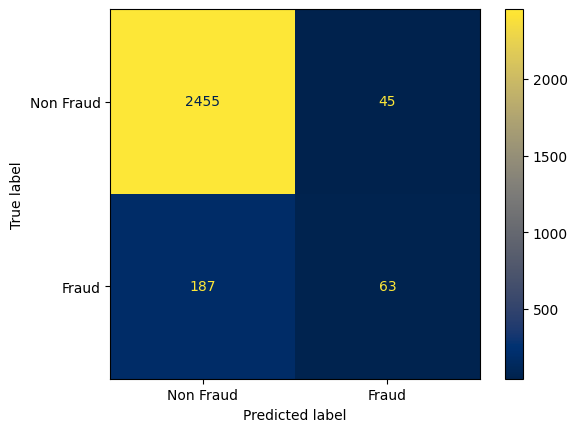

In [44]:
# Note here the .round() is using the 0.5 threshold
plot_confusion_matrix(y_test, y_preds_orig.round())

In [45]:
# Create a report showing the main classification metrics 
no_smote_cls_rpt = classification_report(
    y_test, y_preds_orig.round(), target_names=['non-fraud', 'fraud'], digits=4, output_dict=True)

# Render as DataFrame
df_no_smote_cls_rpt = pd.DataFrame(no_smote_cls_rpt)
df_no_smote_cls_rpt.T

,precision,recall,f1-score,support
non-fraud,0.929220,0.982000,0.954881,2500.000000
fraud,0.583333,0.252000,0.351955,250.000000
accuracy,0.915636,0.915636,0.915636,0.915636
macro avg,0.756277,0.617000,0.653418,2750.000000
weighted avg,0.897776,0.915636,0.900070,2750.000000


### Wrap Up

In [46]:
# Compare the original (no SMOTE) and SMOTE classification reports
df_no_smote_cls_rpt.T.compare(df_smote_cls_rpt.T, 
                              align_axis=0, 
                              keep_shape=True, 
                              keep_equal=True).rename(index={'self': 'No SMOTE', 'other': 'SMOTE'})

precision    recall  f1-score      support
non-fraud    No SMOTE   0.929220  0.982000  0.954881  2500.000000
             SMOTE      0.957076  0.900800  0.928086  2500.000000
fraud        No SMOTE   0.583333  0.252000  0.351955   250.000000
             SMOTE      0.375315  0.596000  0.460587   250.000000
accuracy     No SMOTE   0.915636  0.915636  0.915636     0.915636
             SMOTE      0.873091  0.873091  0.873091     0.873091
macro avg    No SMOTE   0.756277  0.617000  0.653418  2750.000000
             SMOTE      0.666195  0.748400  0.694337  2750.000000
weighted avg No SMOTE   0.897776  0.915636  0.900070  2750.000000
             SMOTE      0.904189  0.873091  0.885586  2750.000000

Given the CMS dataset is highly imbalanced and our objective is to identify fradulent trasactions (minority class), we will focus on evaluating the **recall** and **f1-score** metrics. 

By comparing the results of the baseline and resampled classification reports, we observe that:
1. the recall metric for the minority class increased by 83% (from .31 to .57) for the model trained on the resampled dataset
2. the f1-score increased by 6.7% (from .418 to .446) for the model trained on the resampled dataset

Since our goal is to prevent fradulent transactions, improving the recall metric places a high importance on reducing the number of false negatives (transactions that were labled as *fraud* and the model incorrectly classified them as *non-fraud*). Additionally, improving the f1-score helps because it is the harmonic mean of the precision and recall.

Note: due to randomization during model training individual results may vary slightly for these metrics. 

### Clean up

In [47]:
# Uncomment to clean up endpoints
xgb_predictor.delete_endpoint()
xgb_predictor_baseline.delete_endpoint()

### Data Acknowledgements

The curated dataset used for this lab comes from the following Centers for Medicare & Medicaid Services dataset:
https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider-and-service